In [1]:
import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
from pathlib import Path
root_path = Path.cwd().parent.absolute()
import sys
sys.path.append(str(root_path))
import os

In [2]:

from flax import nnx
import flax
import jax
from jax._src.tree_util import tree_structure
import jax.numpy as jnp
from jaxtyping import Array,PyTree

import matplotlib.pyplot as plt

In [3]:
from architectures.node import NeuralODE
from architectures.utils_node import eval_model
from architectures.architectures import MLP,ResNet
from geometry.G_matrix import G_matrix
from functionals.functions import create_potentials
from functionals.linear_funcitonal_class import LinearPotential
from functionals.functions import zero_potential_fn
from functionals.internal_functional_class import InternalPotential
from functionals.interaction_functional_class import InteractionPotential
from functionals.functional import Potential
from flows.hamiltonian_flow_step import hamiltonian_flow_step
from flows.hamiltonian_flow import initialize_momentum, run_hamiltonian_flow, hamiltonian_trajectory
from parametric_model.parametric_model import ParametricModel
from terminal_criteria.gaussian_case import guassian_wasserstein_squared_distance


In [4]:
# Define the parametric model
parametric_model = ParametricModel(
    parametric_map="mlp", # "node" "resnet"
    architecture=[2, 0, 2], # [input_dim, num_layers, hidden_width]
    activation_fn="sigmoid", # "tanh", "relu", "SinTu", "identity"
    time_dependent=True,    # True or False
    solver="euler", # "euler" or "heun"
    dt0=0.5,
    rhs_model="mlp", # "mlp" or "resnet"
    ref_density="gaussian",
    scale_factor=1e-7
)

In [5]:
# Initialize theta and momentum

_, initial_theta = nnx.split(parametric_model)
initial_p = jax.tree.map(jnp.ones_like, initial_theta)
initial_p = jax.tree.map(lambda x: 1*x, initial_p)

In [9]:
n_samples = 2_000  # Monte Carlo sample size
key = jax.random.PRNGKey(1234)
rngs = nnx.Rngs(key)
# Generate reference samples from lambda = N(0, I)
key, subkey = jax.random.split(key)
test_data_set = jax.random.normal(subkey, (n_samples, 2))
G_mat = G_matrix(parametric_model)


key, subkey = jax.random.split(key)
z_samples = jax.random.normal(subkey, (n_samples, 2))

In [10]:
zero_potential = LinearPotential(zero_potential_fn)
potential = Potential(zero_potential)

In [11]:
step_size = 5e-2
solver = 'cg'
gamma = 1e-2
max_iterations = int(1/step_size)

In [20]:
def cost_functional(p_0: PyTree,
                   parametric_model: nnx.Module,
                   batch_size: int,
                   test_data_set: Array,
                   G_mat: G_matrix,
                   potential: Potential,
                   Sigma_target: Array,
                   alpha: float = 1.0,
                   h: float = 0.01,
                   solver: str = "cg",
                   max_iterations: int = 100,
                   regularization: float = 1e-6,
                   gamma: float = 1e-2,
                   n_iters: int = 3,
                   solver_tol: float = 1e-6,
                   solver_maxiter: int = 50) -> float:
    """
    Compute the full cost functional:
    J(p₀) = α * W₂²((T_{θ₁})_# λ, ρ₁) + A[θ(·)]
    
    This function is fully differentiable w.r.t. p_0 via JAX autodiff.
    Both terms are computed from a single forward solve of the Hamiltonian system.
    
    Args:
        p_0: Initial momentum PyTree
        parametric_model: Initial ParametricModel
        batch_size: Number of samples for Monte Carlo
        test_data_set: Test dataset
        G_mat: G-matrix object
        potential: Potential instance
        Sigma_target: Target covariance matrix (d, d)
        alpha: Weight for Wasserstein term (α > 0)
        h: Time step size
        solver: Linear solver type
        max_iterations: Number of Hamiltonian steps
        [other solver parameters...]
    
    Returns:
        cost: Scalar value J(p₀) = α * W₂² + Action
    """
    
    # ===== SINGLE FORWARD SOLVE =====
    # Run Hamiltonian trajectory from p₀
    trajectories = hamiltonian_trajectory(
        parametric_model=parametric_model,
        batch_size=batch_size,
        test_data_set=test_data_set,
        G_mat=G_mat,
        potential=potential,
        initial_momentum=p_0,
        h=h,
        solver=solver,
        max_iterations=max_iterations,
        regularization=regularization,
        gamma=gamma,
        n_iters=n_iters,
        solver_tol=solver_tol,
        solver_maxiter=solver_maxiter
    )
    
    # Extract trajectories
    theta_history = trajectories['theta_history']
    momentum_history = trajectories['momentum_history']
    theta_final = theta_history[-1]  # θ(1)
    n_steps = len(theta_history)
    
    # ===== TERM 1: WASSERSTEIN DISTANCE =====
    # Extract weight matrix from final parameters θ₁
    theta_final_leaves = jax.tree.leaves(theta_final)
    W_final = theta_final_leaves[0]  # (d, d) weight matrix
    
    # Compute W₂²((T_{θ₁})_# λ, ρ₁)
    wasserstein_squared = guassian_wasserstein_squared_distance(W_final, Sigma_target)
    
    # ===== TERM 2: ACTION FUNCTIONAL =====
    # Generate samples for G matrix computation
    key = jax.random.PRNGKey(0)
    problem_dim = test_data_set.shape[1]
    z_samples = jax.random.normal(key, (batch_size, problem_dim))
    
    # Compute kinetic energy at each time step: KE(t) = ½ p^T G^{-1} p
    kinetic_energies = []
    
    for i in range(n_steps):
        theta_i = theta_history[i]
        p_i = momentum_history[i]
        
        # Solve G(θᵢ) ηᵢ = pᵢ
        # eta_i, _ = G_mat.solve_system(
        #     z_samples=z_samples,
        #     b=p_i,
        #     params=theta_i,
        #     tol=solver_tol,
        #     maxiter=solver_maxiter,
        #     method=solver,
        #     regularization=regularization
        # )
        
        # # KE = ½ p^T G^{-1} p
        # ke_i = 0.5 * sum(jax.tree.leaves(jax.tree.map(
        #     lambda p, eta: jnp.sum(p * eta), p_i, eta_i
        # )))
        ke_i = G_mat.inner_product(p_i,p_i,z_samples,theta_i)
        kinetic_energies.append(ke_i)
    
    kinetic_energies = jnp.array(kinetic_energies)
    
    # Trapezoidal integration for action
    action = h * (
        kinetic_energies[0] / 2.0 +
        jnp.sum(kinetic_energies[1:-1]) +
        kinetic_energies[-1] / 2.0
    )

    jax.debug.print("Wasserstein Squared: {ws}, Action: {ac}", ws=wasserstein_squared, ac=action)
    
    # ===== COMBINE TERMS =====
    total_cost = alpha * wasserstein_squared + action
    
    return total_cost

In [ ]:
from typing import Tuple
def optimize_initial_momentum(
    p_0_init: PyTree,
    parametric_model: nnx.Module,
    batch_size: int,
    test_data_set: Array,
    G_mat: G_matrix,
    potential: Potential,
    Sigma_target: Array,
    alpha: float = 1.0,
    h: float = 0.01,
    solver: str = "cg",
    max_iterations: int = 100,
    # Hamiltonian solver params
    regularization: float = 1e-6,
    gamma: float = 1e-2,
    n_iters: int = 3,
    solver_tol: float = 1e-6,
    solver_maxiter: int = 50,
    # Optimization params
    optimizer: str = "adam",
    learning_rate: float = 1e-3,
    num_optimization_steps: int = 100,
    verbose: bool = True
) -> dict:
    """
    Optimize initial momentum p₀ to minimize the cost functional J(p₀).
    
    Args:
        p_0_init: Initial guess for momentum
        parametric_model: Initial ParametricModel
        batch_size: Number of samples for Monte Carlo
        test_data_set: Test dataset
        G_mat: G-matrix object
        potential: Potential instance
        Sigma_target: Target covariance matrix (d, d)
        alpha: Weight for Wasserstein term
        h: Time step for Hamiltonian flow
        solver: Linear solver type
        max_iterations: Number of Hamiltonian steps
        [Hamiltonian solver params...]
        optimizer: Optimizer type ("adam", "sgd", "rmsprop")
        learning_rate: Learning rate for optimizer
        num_optimization_steps: Number of optimization iterations
        verbose: Print progress
    
    Returns:
        results: Dictionary containing:
            - 'optimal_p0': Optimized initial momentum
            - 'optimal_cost': Final cost value
            - 'cost_history': List of cost values during optimization
            - 'wasserstein_history': List of Wasserstein distances
            - 'action_history': List of action values
            - 'grad_norm_history': List of gradient norms
            - 'final_theta': Final parameters θ(1) from optimal p₀
    """
    
    import optax
    
    # Define the cost function with fixed parameters
    def cost_fn(p_0: PyTree) -> float:
        return cost_functional(
            p_0=p_0,
            parametric_model=parametric_model,
            batch_size=batch_size,
            test_data_set=test_data_set,
            G_mat=G_mat,
            potential=potential,
            Sigma_target=Sigma_target,
            alpha=alpha,
            h=h,
            solver=solver,
            max_iterations=max_iterations,
            regularization=regularization,
            gamma=gamma,
            n_iters=n_iters,
            solver_tol=solver_tol,
            solver_maxiter=solver_maxiter
        )
    
    # Function to compute cost and separate components for logging
    def cost_fn_detailed(p_0: PyTree) -> Tuple[float, dict]:
        """Compute cost and return detailed breakdown."""
        # Run trajectory
        trajectories = hamiltonian_trajectory(
            parametric_model=parametric_model,
            batch_size=batch_size,
            test_data_set=test_data_set,
            G_mat=G_mat,
            potential=potential,
            initial_momentum=p_0,
            h=h,
            solver=solver,
            max_iterations=max_iterations,
            regularization=regularization,
            gamma=gamma,
            n_iters=n_iters,
            solver_tol=solver_tol,
            solver_maxiter=solver_maxiter
        )
        
        # Wasserstein term
        theta_final = trajectories['theta_history'][-1]
        theta_final_leaves = jax.tree.leaves(theta_final)
        W_final = theta_final_leaves[0]
        wasserstein_sq = guassian_wasserstein_squared_distance(W_final, Sigma_target)
        
        # Action term (recompute for logging)
        theta_history = trajectories['theta_history']
        momentum_history = trajectories['momentum_history']
        key = jax.random.PRNGKey(0)
        problem_dim = test_data_set.shape[1]
        z_samples = jax.random.normal(key, (batch_size, problem_dim))
        
        kinetic_energies = []
        for theta_i, p_i in zip(theta_history, momentum_history):
            ke_i = G_mat.inner_product(p_i,p_i,z_samples,theta_i)
            kinetic_energies.append(ke_i)
        
        kinetic_energies = jnp.array(kinetic_energies)
        action = h * (kinetic_energies[0] / 2.0 + jnp.sum(kinetic_energies[1:-1]) + 
                     kinetic_energies[-1] / 2.0)
        
        total_cost = alpha * wasserstein_sq + action
        
        return total_cost, {
            'wasserstein': float(wasserstein_sq),
            'action': float(action),
            'theta_final': theta_final
        }
    
    # Setup optimizer
    if optimizer == "adam":
        opt = optax.adam(learning_rate)
    elif optimizer == "sgd":
        opt = optax.sgd(learning_rate)
    elif optimizer == "rmsprop":
        opt = optax.rmsprop(learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer}")
    
    opt_state = opt.init(p_0_init)
    
    # Initialize current momentum
    current_p0 = p_0_init
    
    # Storage for history
    cost_history = []
    wasserstein_history = []
    action_history = []
    grad_norm_history = []
    
    # Optimization loop
    if verbose:
        print(f"Starting optimization with {optimizer}, lr={learning_rate}")
        print(f"{'Step':<6} {'Cost':<12} {'Wasserstein²':<12} {'Action':<12} {'||∇||':<12}")
        print("-" * 60)
        
    
    for step in range(num_optimization_steps):
        # Compute cost, gradient, and detailed info
        cost_val, grad_p0 = jax.value_and_grad(cost_fn)(current_p0)
        
        # Compute gradient norm
        grad_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(
            lambda g: jnp.sum(g**2), grad_p0
        ))))
        
        # Get detailed breakdown (for logging only)
        if verbose and (step % 10 == 0 or step == num_optimization_steps - 1):
            _, details = cost_fn_detailed(current_p0)
            wasserstein_val = details['wasserstein']
            action_val = details['action']
            theta_final = details['theta_final']
            
            print(f"{step:<6} {cost_val:<12.6f} {wasserstein_val:<12.6f} "
                  f"{action_val:<12.6f} {grad_norm:<12.6e}")
            
            wasserstein_history.append(wasserstein_val)
            action_history.append(action_val)
            if step > 0:
                prev_terminal_samples = terminal_samples
            # Print pushforward of theta final
            terminal_samples = parametric_model(samples=z_samples, params=theta_final)
            plt.scatter(terminal_samples[:,0], terminal_samples[:,1],label='Current Step')
            if step > 0:
                plt.scatter(prev_terminal_samples[:,0], prev_terminal_samples[:,1],label='Previous Step',alpha=0.5)
            plt.legend()
            plt.title(f"Step {step} Terminal Samples")
            plt.show()
            # print(f"Final Theta: {theta_final}")
            theta_final_leaves = jax.tree.leaves(theta_final)
            W_final = theta_final_leaves[0]
            print(f'Final parameter:{theta_final_leaves}')
            print(f"Final Weight Matrix:\n{W_final.T@W_final}")

            
        
        cost_history.append(float(cost_val))
        grad_norm_history.append(float(grad_norm))
        
        # Update parameters using optimizer
        updates, opt_state = opt.update(grad_p0, opt_state, current_p0)
        current_p0 = optax.apply_updates(current_p0, updates)
    
    # Final evaluation
    final_cost, final_details = cost_fn_detailed(current_p0)
    
    if verbose:
        print("-" * 60)
        print(f"Optimization complete!")
        print(f"Initial cost: {cost_history[0]:.6f}")
        print(f"Final cost:   {final_cost:.6f}")
        print(f"Improvement:  {cost_history[0] - final_cost:.6f}")
    
    return {
        'optimal_p0': current_p0,
        'optimal_cost': float(final_cost),
        'cost_history': cost_history,
        'wasserstein_history': wasserstein_history,
        'action_history': action_history,
        'grad_norm_history': grad_norm_history,
        'final_theta': final_details['theta_final'],
        'final_wasserstein': final_details['wasserstein'],
        'final_action': final_details['action']
    }

Starting optimization with adam, lr=0.05
Step   Cost         Wasserstein² Action       ||∇||       
------------------------------------------------------------
Wasserstein Squared: 1.7276873588562012, Action: 0.06031854823231697
0      1.788006     1.727687     0.060319     2.240741e+00


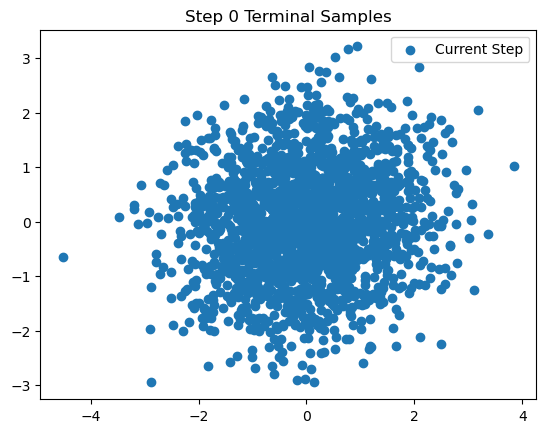

Final parameter:[Array([[ 1.1464311 ,  0.18322843],
       [-0.0377381 ,  0.99521875]], dtype=float32)]
Final Weight Matrix:
[[1.3157284  0.17250112]
 [0.17250112 1.0240331 ]]
Wasserstein Squared: 1.557499885559082, Action: 0.0691923126578331
Wasserstein Squared: 1.404773235321045, Action: 0.09314718097448349
Wasserstein Squared: 1.2654428482055664, Action: 0.12423589080572128
Wasserstein Squared: 1.1338601112365723, Action: 0.16148117184638977
Wasserstein Squared: 1.0104093551635742, Action: 0.20602057874202728
Wasserstein Squared: 0.8956618309020996, Action: 0.2577598989009857
Wasserstein Squared: 0.7923474311828613, Action: 0.31602320075035095
Wasserstein Squared: 0.7003555297851562, Action: 0.37919050455093384
Wasserstein Squared: 0.6204047203063965, Action: 0.44423919916152954
Wasserstein Squared: 0.5517420768737793, Action: 0.508243978023529
10     1.059986     0.551742     0.508244     3.153647e-01


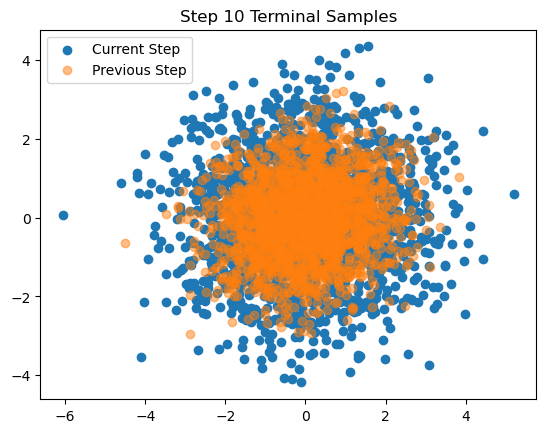

Final parameter:[Array([[1.5397375 , 0.0074586 ],
       [0.04948115, 1.4181156 ]], dtype=float32)]
Final Weight Matrix:
[[2.3732398  0.08165427]
 [0.08165427 2.0111074 ]]
Wasserstein Squared: 0.49361085891723633, Action: 0.5678226351737976
Wasserstein Squared: 0.4461679458618164, Action: 0.6210470795631409
Wasserstein Squared: 0.40848445892333984, Action: 0.6659622192382812
Wasserstein Squared: 0.38048887252807617, Action: 0.7018953561782837
Wasserstein Squared: 0.36132240295410156, Action: 0.7279168963432312
Wasserstein Squared: 0.34964561462402344, Action: 0.7442712783813477
Wasserstein Squared: 0.3444552421569824, Action: 0.7516272664070129
Wasserstein Squared: 0.3453073501586914, Action: 0.7504079937934875
Wasserstein Squared: 0.3512563705444336, Action: 0.7421694993972778
Wasserstein Squared: 0.361508846282959, Action: 0.7275951504707336
20     1.089104     0.361509     0.727595     5.559501e-01


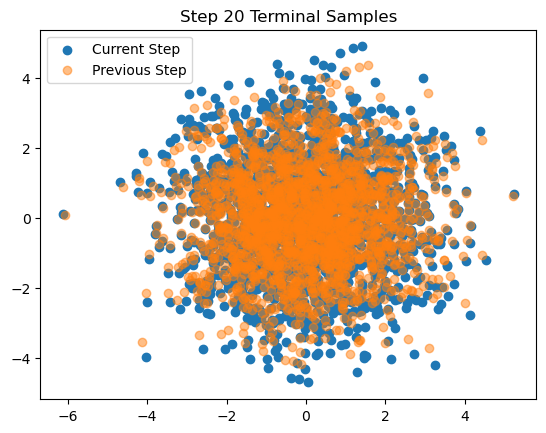

Final parameter:[Array([[ 1.5548819 ,  0.0028535 ],
       [-0.00381417,  1.5957936 ]], dtype=float32)]
Final Weight Matrix:
[[ 2.4176724e+00 -1.6497672e-03]
 [-1.6497672e-03  2.5465653e+00]]
Wasserstein Squared: 0.3761434555053711, Action: 0.708512008190155
Wasserstein Squared: 0.39403772354125977, Action: 0.6859408617019653
Wasserstein Squared: 0.414278507232666, Action: 0.660507321357727
Wasserstein Squared: 0.4365811347961426, Action: 0.6331790685653687
Wasserstein Squared: 0.4598817825317383, Action: 0.6051180958747864
Wasserstein Squared: 0.4835786819458008, Action: 0.577142059803009
Wasserstein Squared: 0.5069499015808105, Action: 0.5502994656562805
Wasserstein Squared: 0.5294160842895508, Action: 0.5253224968910217
Wasserstein Squared: 0.5497899055480957, Action: 0.5027443766593933
Wasserstein Squared: 0.5682129859924316, Action: 0.48325109481811523
30     1.051464     0.568213     0.483251     2.059159e-01


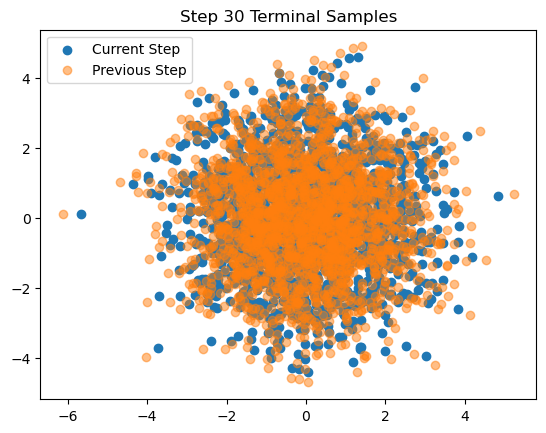

Final parameter:[Array([[ 1.4385178 ,  0.00179815],
       [-0.0043718 ,  1.497055  ]], dtype=float32)]
Final Weight Matrix:
[[ 2.0693526  -0.00395816]
 [-0.00395816  2.241177  ]]
Wasserstein Squared: 0.5839705467224121, Action: 0.46688809990882874
Wasserstein Squared: 0.5965614318847656, Action: 0.45378193259239197
Wasserstein Squared: 0.6059246063232422, Action: 0.44397974014282227
Wasserstein Squared: 0.6128377914428711, Action: 0.437426894903183
Wasserstein Squared: 0.616762638092041, Action: 0.43375036120414734
Wasserstein Squared: 0.6178317070007324, Action: 0.4325747489929199
Wasserstein Squared: 0.6165571212768555, Action: 0.4340370297431946
Wasserstein Squared: 0.612849235534668, Action: 0.437307745218277
Wasserstein Squared: 0.6080355644226074, Action: 0.4424450993537903
Wasserstein Squared: 0.6011695861816406, Action: 0.44885024428367615
40     1.050020     0.601170     0.448850     1.813342e-01


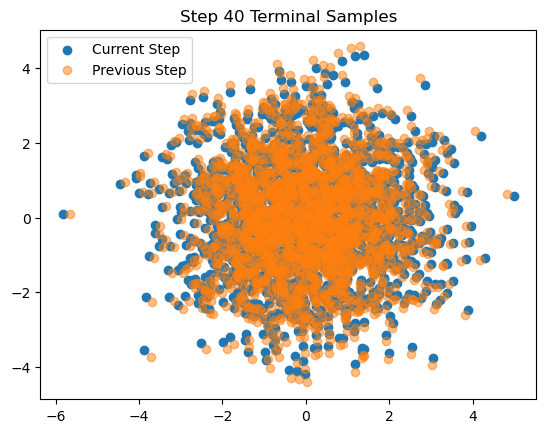

Final parameter:[Array([[1.4818420e+00, 2.4360933e-04],
       [1.3319095e-02, 1.4232693e+00]], dtype=float32)]
Final Weight Matrix:
[[2.1960332  0.01931765]
 [0.01931765 2.0256953 ]]
Wasserstein Squared: 0.5936098098754883, Action: 0.4561355710029602
Wasserstein Squared: 0.5853471755981445, Action: 0.4643199145793915
Wasserstein Squared: 0.5770354270935059, Action: 0.4725135266780853
Wasserstein Squared: 0.568631649017334, Action: 0.48052945733070374
Wasserstein Squared: 0.5604333877563477, Action: 0.48818278312683105
Wasserstein Squared: 0.5530776977539062, Action: 0.49490728974342346
Wasserstein Squared: 0.5464715957641602, Action: 0.5009642839431763
Wasserstein Squared: 0.5411438941955566, Action: 0.5059502124786377
Wasserstein Squared: 0.5365467071533203, Action: 0.5098538398742676
Wasserstein Squared: 0.5330605506896973, Action: 0.5129217505455017
50     1.045982     0.533061     0.512922     7.007691e-02


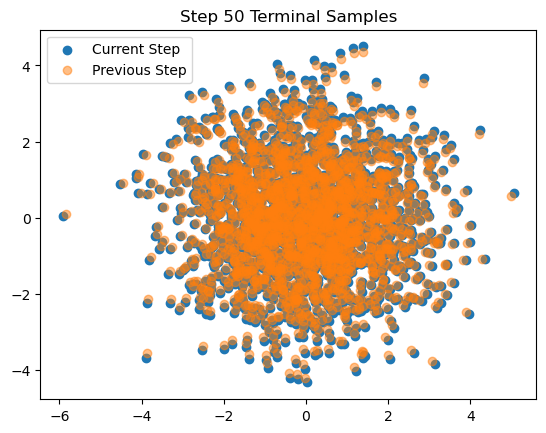

Final parameter:[Array([[1.5026084 , 0.01336431],
       [0.00189188, 1.4656155 ]], dtype=float32)]
Final Weight Matrix:
[[2.2578356  0.02285408]
 [0.02285408 2.1482074 ]]
Wasserstein Squared: 0.5307326316833496, Action: 0.5150753259658813
Wasserstein Squared: 0.5295138359069824, Action: 0.5161321759223938
Wasserstein Squared: 0.5293045043945312, Action: 0.5163835883140564
Wasserstein Squared: 0.5296130180358887, Action: 0.5161108374595642
Wasserstein Squared: 0.5305991172790527, Action: 0.5153356790542603
Wasserstein Squared: 0.5320582389831543, Action: 0.5140913724899292
Wasserstein Squared: 0.5338244438171387, Action: 0.5121964812278748
Wasserstein Squared: 0.535736083984375, Action: 0.5104047656059265
Wasserstein Squared: 0.5376725196838379, Action: 0.5087682604789734
Wasserstein Squared: 0.5395412445068359, Action: 0.5068637728691101
60     1.046405     0.539541     0.506864     8.007682e-02


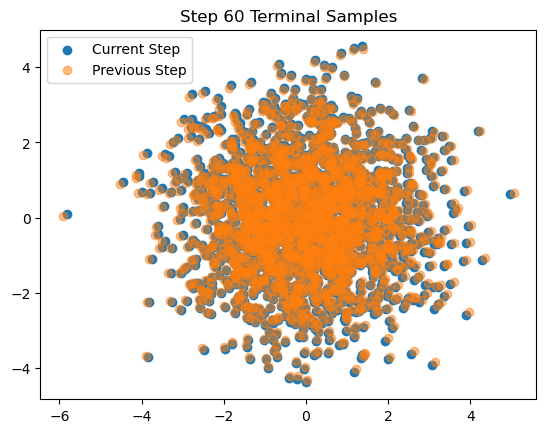

Final parameter:[Array([[1.4741509 , 0.00337601],
       [0.00969602, 1.487218  ]], dtype=float32)]
Final Weight Matrix:
[[2.173215   0.01939685]
 [0.01939685 2.211829  ]]
Wasserstein Squared: 0.5412688255310059, Action: 0.5047351121902466
Wasserstein Squared: 0.54278564453125, Action: 0.5031337141990662
Wasserstein Squared: 0.5440998077392578, Action: 0.5016182065010071
Wasserstein Squared: 0.5455341339111328, Action: 0.5004499554634094
Wasserstein Squared: 0.5461082458496094, Action: 0.4993917644023895
Wasserstein Squared: 0.5468435287475586, Action: 0.4986954629421234
Wasserstein Squared: 0.5471014976501465, Action: 0.49809327721595764
Wasserstein Squared: 0.5479235649108887, Action: 0.4975929260253906
Wasserstein Squared: 0.5479817390441895, Action: 0.4971637725830078
Wasserstein Squared: 0.5483150482177734, Action: 0.49702486395835876
70     1.045340     0.548315     0.497025     1.849203e-02


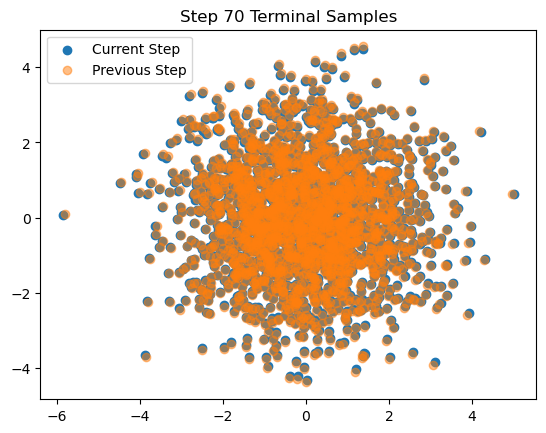

Final parameter:[Array([[1.4874161 , 0.00696577],
       [0.00382926, 1.4656643 ]], dtype=float32)]
Final Weight Matrix:
[[2.2124217  0.01597341]
 [0.01597341 2.1482203 ]]
Wasserstein Squared: 0.5486187934875488, Action: 0.49692389369010925
Wasserstein Squared: 0.5488834381103516, Action: 0.496605783700943
Wasserstein Squared: 0.5491328239440918, Action: 0.49652335047721863
Wasserstein Squared: 0.5493454933166504, Action: 0.4964371621608734
Wasserstein Squared: 0.5495352745056152, Action: 0.4961148202419281
Wasserstein Squared: 0.549687385559082, Action: 0.4960246980190277
Wasserstein Squared: 0.5497879981994629, Action: 0.4959418475627899
Wasserstein Squared: 0.5498218536376953, Action: 0.495646208524704
Wasserstein Squared: 0.5497908592224121, Action: 0.49585065245628357
Wasserstein Squared: 0.5500245094299316, Action: 0.4956350326538086
80     1.045660     0.550025     0.495635     1.855327e-02


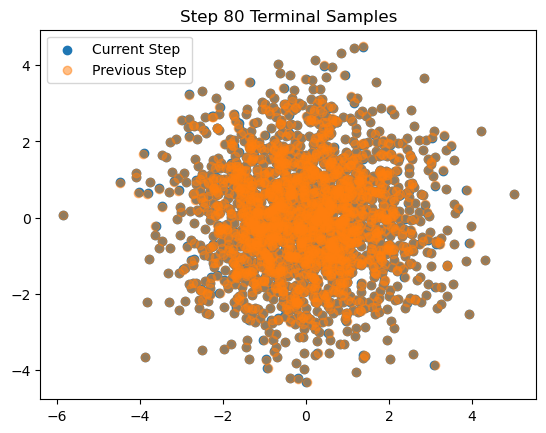

Final parameter:[Array([[1.4863842 , 0.0046741 ],
       [0.00560574, 1.4650522 ]], dtype=float32)]
Final Weight Matrix:
[[2.2093694  0.01516021]
 [0.01516021 2.1464    ]]
Wasserstein Squared: 0.5494985580444336, Action: 0.4959355890750885
Wasserstein Squared: 0.5495586395263672, Action: 0.4958285987377167
Wasserstein Squared: 0.5491948127746582, Action: 0.4962437152862549
Wasserstein Squared: 0.5487308502197266, Action: 0.49670371413230896
Wasserstein Squared: 0.5481963157653809, Action: 0.4972096383571625
Wasserstein Squared: 0.5475897789001465, Action: 0.4977532923221588
Wasserstein Squared: 0.546940803527832, Action: 0.49854955077171326


KeyboardInterrupt: 

In [51]:
# Setup your test case
parametric_model = ParametricModel(
    parametric_map="mlp",
    architecture=[2, 0, 2],
    scale_factor=1e-5  # Small perturbation for numerical stability
)

# Initialize momentum (e.g., zeros or small random)
_, p_0_init = nnx.split(parametric_model)
p_0_init = jax.tree.map(lambda x: 0.1 * jax.random.normal(jax.random.PRNGKey(0), x.shape), p_0_init)
# p_0_init = jax.tree.map(jnp.zeros_like, p_0_init)

# Target Gaussian
Sigma_target = jnp.array([[4.0, 0.0], [0.0, 4.0]])  # N(0, 2I)

h = 0.1
max_iterations = int(1/h)

# Run optimization
results = optimize_initial_momentum(
    p_0_init=p_0_init,
    parametric_model=parametric_model,
    batch_size=1000,
    test_data_set=test_data_set,
    G_mat=G_mat,
    potential=potential,
    Sigma_target=Sigma_target,
    alpha=1.0,
    h=h,
    solver="minres",
    max_iterations=max_iterations,
    optimizer="adam",
    learning_rate=0.05,
    num_optimization_steps=200,
    verbose=True
)

# Access results
optimal_p0 = results['optimal_p0']
final_theta = results['final_theta']
print(f"Final Wasserstein distance: {jnp.sqrt(results['final_wasserstein']):.6f}")

In [ ]:
optimal_p0

State({
  'model': {
    'layers': {
      0: {
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[ 0.943746  ,  0.84325963],
                 [-0.85952777,  0.9118277 ]], dtype=float32)
        )
      }
    }
  }
})

In [47]:
trajectories_optimal = hamiltonian_trajectory(
    parametric_model=parametric_model,
    batch_size=2000,
    test_data_set=test_data_set,
    G_mat=G_mat,
    potential=potential,
    initial_momentum=optimal_p0,
    h=h,
    solver="minres",
    max_iterations=max_iterations,
)

In [48]:
trajectories_optimal.keys()

dict_keys(['theta_history', 'momentum_history', 'theta_dot_history', 'p_dot_history', 'time_steps', 'energy_history', 'hamiltonian_history', 'final_parametric_model', 'final_momentum'])

In [49]:
theta_history_optimal = trajectories_optimal['theta_history']

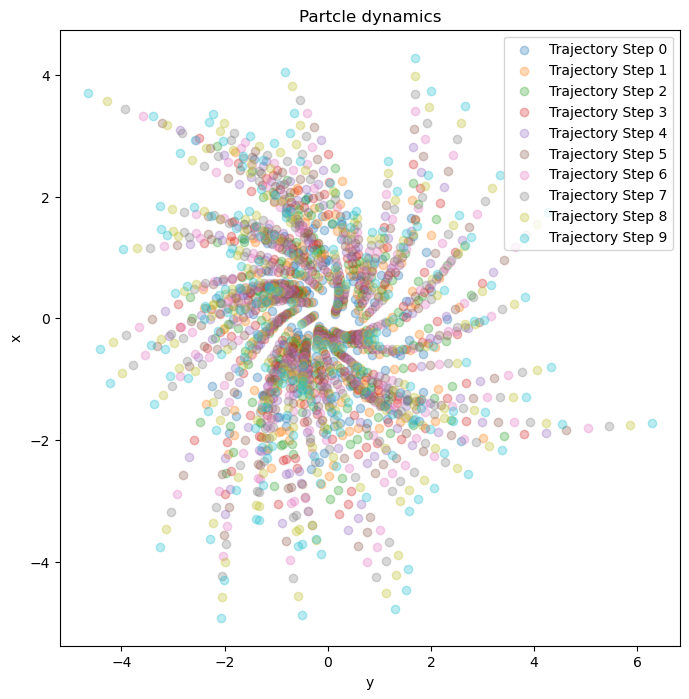

In [50]:
key,subkey = jax.random.split(key)
test_data_set = jax.random.normal(subkey, (200, 2))

fig = plt.figure(figsize=(8,8))

for i, theta in enumerate(theta_history_optimal):
    samples = parametric_model(samples=test_data_set, params=theta)
    plt.scatter(samples[:,0], samples[:,1], alpha=0.3,label=f'Trajectory Step {i}')

plt.title("Partcle dynamics")
plt.xlabel("y")
plt.ylabel("x")
plt.legend()
plt.show()

In [52]:
def optimize_with_lagrange_multiplier_update(
    p_0_init: PyTree,
    parametric_model: nnx.Module,
    batch_size: int,
    test_data_set: Array,
    G_mat: G_matrix,
    potential: Potential,
    Sigma_target: Array,
    h: float = 0.01,
    solver: str = "cg",
    max_iterations: int = 100,
    regularization: float = 1e-6,
    gamma: float = 1e-2,
    n_iters: int = 3,
    solver_tol: float = 1e-6,
    solver_maxiter: int = 50,
    # Lagrange multiplier update params
    alpha_init: float = 0.1,
    alpha_update_rate: float = 2.0,
    alpha_max: float = 1e6,
    max_outer_iterations: int = 20,
    inner_optimization_steps: int = 50,
    target_wasserstein_tol: float = 1e-4,
    # Inner optimizer params
    optimizer: str = "adam",
    learning_rate: float = 1e-2,
    verbose: bool = True
) -> dict:
    """
    Optimize initial momentum p₀ with adaptive Lagrange multiplier updates.
    
    Solves the constrained problem:
        min_{p₀} A[θ(·; p₀)]
        subject to: W₂²((T_{θ(1)})_# λ, ρ₁) ≈ 0
    
    Using augmented Lagrangian method:
        L(p₀, α) = A[θ(·)] + α · W₂²
    
    Args:
        p_0_init: Initial guess for momentum
        parametric_model: Initial ParametricModel
        batch_size: Number of samples for Monte Carlo
        test_data_set: Test dataset
        G_mat: G-matrix object
        potential: Potential instance
        Sigma_target: Target covariance matrix (d, d)
        h: Time step for Hamiltonian flow
        solver: Linear solver type
        max_iterations: Number of Hamiltonian steps
        [Hamiltonian solver params...]
        alpha_init: Initial Lagrange multiplier
        alpha_update_rate: Multiplicative factor for α update (β > 1)
        alpha_max: Maximum allowed α value
        max_outer_iterations: Maximum outer iterations
        inner_optimization_steps: Optimization steps per outer iteration
        target_wasserstein_tol: Convergence tolerance for W₂²
        optimizer: Inner optimizer type
        learning_rate: Learning rate for inner optimizer
        verbose: Print progress
    
    Returns:
        results: Dictionary containing:
            - 'optimal_p0': Optimized initial momentum
            - 'optimal_alpha': Final Lagrange multiplier
            - 'final_wasserstein': Final Wasserstein² distance
            - 'final_action': Final action value
            - 'final_theta': Final parameters θ(1)
            - 'alpha_history': History of α values
            - 'wasserstein_history': History of W₂² values
            - 'action_history': History of action values
            - 'cost_history': History of total costs
    """
    
    import optax
    
    # Initialize
    current_p0 = p_0_init
    current_alpha = alpha_init
    
    # Storage for outer loop history
    alpha_history = [current_alpha]
    outer_wasserstein_history = []
    outer_action_history = []
    outer_cost_history = []
    
    if verbose:
        print("=" * 80)
        print("ADAPTIVE LAGRANGE MULTIPLIER OPTIMIZATION")
        print("=" * 80)
        print(f"Initial α = {current_alpha:.6f}")
        print(f"Target W₂² tolerance = {target_wasserstein_tol:.2e}")
        print(f"α update rate = {alpha_update_rate}")
        print("=" * 80)
    
    # Outer loop: Update Lagrange multiplier
    for outer_iter in range(max_outer_iterations):
        if verbose:
            print(f"\n{'='*80}")
            print(f"OUTER ITERATION {outer_iter + 1}/{max_outer_iterations}")
            print(f"Current α = {current_alpha:.6f}")
            print(f"{'='*80}")
        
        # Define cost function with current α
        def cost_fn_fixed_alpha(p_0: PyTree) -> float:
            return cost_functional(
                p_0=p_0,
                parametric_model=parametric_model,
                batch_size=batch_size,
                test_data_set=test_data_set,
                G_mat=G_mat,
                potential=potential,
                Sigma_target=Sigma_target,
                alpha=current_alpha,
                h=h,
                solver=solver,
                max_iterations=max_iterations,
                regularization=regularization,
                gamma=gamma,
                n_iters=n_iters,
                solver_tol=solver_tol,
                solver_maxiter=solver_maxiter
            )
        
        # Setup optimizer for inner loop
        if optimizer == "adam":
            opt = optax.adam(learning_rate)
        elif optimizer == "sgd":
            opt = optax.sgd(learning_rate)
        elif optimizer == "rmsprop":
            opt = optax.rmsprop(learning_rate)
        else:
            raise ValueError(f"Unknown optimizer: {optimizer}")
        
        opt_state = opt.init(current_p0)
        
        # Inner optimization loop
        if verbose:
            print(f"\nInner optimization ({inner_optimization_steps} steps):")
            print(f"{'Step':<6} {'Cost':<12} {'Wasserstein²':<12} {'Action':<12} {'||∇||':<12}")
            print("-" * 60)
        
        best_cost = float('inf')
        best_p0 = current_p0
        
        for inner_step in range(inner_optimization_steps):
            # Compute gradient
            cost_val, grad_p0 = jax.value_and_grad(cost_fn_fixed_alpha)(current_p0)
            
            # Track best solution
            if cost_val < best_cost:
                best_cost = cost_val
                best_p0 = jax.tree.map(lambda x: x, current_p0)
            
            # Compute gradient norm
            grad_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(
                lambda g: jnp.sum(g**2), grad_p0
            ))))
            
            # Print progress
            if verbose and (inner_step % 10 == 0 or inner_step == inner_optimization_steps - 1):
                # Get detailed breakdown for logging
                traj = hamiltonian_trajectory(
                    parametric_model=parametric_model,
                    batch_size=batch_size,
                    test_data_set=test_data_set,
                    G_mat=G_mat,
                    potential=potential,
                    initial_momentum=current_p0,
                    h=h,
                    solver=solver,
                    max_iterations=max_iterations,
                    regularization=regularization,
                    gamma=gamma,
                    n_iters=n_iters,
                    solver_tol=solver_tol,
                    solver_maxiter=solver_maxiter
                )
                
                theta_final = traj['theta_history'][-1]
                W_final = jax.tree.leaves(theta_final)[0]
                wasserstein_sq = guassian_wasserstein_squared_distance(W_final, Sigma_target)
                action_val = cost_val - current_alpha * wasserstein_sq
                
                print(f"{inner_step:<6} {cost_val:<12.6f} {wasserstein_sq:<12.6e} "
                      f"{action_val:<12.6f} {grad_norm:<12.6e}")
            
            # Update parameters
            updates, opt_state = opt.update(grad_p0, opt_state, current_p0)
            current_p0 = optax.apply_updates(current_p0, updates)
        
        # Use best solution from inner optimization
        current_p0 = best_p0
        
        # Evaluate final state of inner optimization
        final_traj = hamiltonian_trajectory(
            parametric_model=parametric_model,
            batch_size=batch_size,
            test_data_set=test_data_set,
            G_mat=G_mat,
            potential=potential,
            initial_momentum=current_p0,
            h=h,
            solver=solver,
            max_iterations=max_iterations,
            regularization=regularization,
            gamma=gamma,
            n_iters=n_iters,
            solver_tol=solver_tol,
            solver_maxiter=solver_maxiter
        )
        
        theta_final = final_traj['theta_history'][-1]
        W_final = jax.tree.leaves(theta_final)[0]
        final_wasserstein = float(guassian_wasserstein_squared_distance(W_final, Sigma_target))
        final_cost = float(cost_fn_fixed_alpha(current_p0))
        final_action = final_cost - current_alpha * final_wasserstein
        
        # Store history
        outer_wasserstein_history.append(final_wasserstein)
        outer_action_history.append(final_action)
        outer_cost_history.append(final_cost)
        
        if verbose:
            print(f"\n{'='*80}")
            print(f"OUTER ITERATION {outer_iter + 1} SUMMARY:")
            print(f"  Final Cost:        {final_cost:.6f}")
            print(f"  Wasserstein²:      {final_wasserstein:.6e}")
            print(f"  Action:            {final_action:.6f}")
            print(f"  Current α:         {current_alpha:.6f}")
            
            # Compute final Σ_push for diagnostics
            Sigma_push = W_final @ W_final.T
            print(f"  Final Σ_push diag: [{Sigma_push[0,0]:.4f}, {Sigma_push[1,1]:.4f}]")
            print(f"  Target Σ diag:     [{Sigma_target[0,0]:.4f}, {Sigma_target[1,1]:.4f}]")
        
        # Check convergence
        if final_wasserstein < target_wasserstein_tol:
            if verbose:
                print(f"\n{'='*80}")
                print(f"✓ CONVERGED! Wasserstein² = {final_wasserstein:.6e} < {target_wasserstein_tol:.2e}")
                print(f"{'='*80}")
            break
        
        # Update Lagrange multiplier
        # Augmented Lagrangian update: α^(k+1) = α^(k) * β
        prev_alpha = current_alpha
        current_alpha = min(current_alpha * alpha_update_rate, alpha_max)
        alpha_history.append(current_alpha)
        
        if verbose:
            print(f"  Updating α: {prev_alpha:.6f} → {current_alpha:.6f}")
            
        if current_alpha >= alpha_max:
            if verbose:
                print(f"\n⚠ WARNING: α reached maximum value {alpha_max}")
            break
    else:
        if verbose:
            print(f"\n{'='*80}")
            print(f"⚠ WARNING: Maximum outer iterations reached without convergence")
            print(f"  Final Wasserstein² = {final_wasserstein:.6e} > {target_wasserstein_tol:.2e}")
            print(f"{'='*80}")
    
    if verbose:
        print(f"\n{'='*80}")
        print("FINAL RESULTS:")
        print(f"  Optimal α:         {current_alpha:.6f}")
        print(f"  Final Action:      {final_action:.6f}")
        print(f"  Final Wasserstein²: {final_wasserstein:.6e}")
        print(f"  Final Cost:        {final_cost:.6f}")
        print(f"  Outer iterations:  {len(outer_wasserstein_history)}")
        print(f"{'='*80}\n")
    
    return {
        'optimal_p0': current_p0,
        'optimal_alpha': current_alpha,
        'final_wasserstein': final_wasserstein,
        'final_action': final_action,
        'final_cost': final_cost,
        'final_theta': theta_final,
        'alpha_history': alpha_history,
        'wasserstein_history': outer_wasserstein_history,
        'action_history': outer_action_history,
        'cost_history': outer_cost_history
    }

In [54]:
# Initialize
parametric_model = ParametricModel(
    parametric_map="mlp",
    architecture=[2, 0, 2],
    scale_factor=1e-5
)

# Initial momentum (small random or zeros)
_, p_0_init = nnx.split(parametric_model)
p_0_init = jax.tree.map(lambda x: 0.01 * jax.random.normal(jax.random.PRNGKey(42), x.shape), p_0_init)

# Target
Sigma_target = jnp.array([[4.0, 0.0], [0.0, 4.0]])

h = 0.05
max_iterations = int(1/h)

# Run optimization with adaptive α
results = optimize_with_lagrange_multiplier_update(
    p_0_init=p_0_init,
    parametric_model=parametric_model,
    batch_size=1000,
    test_data_set=test_data_set,
    G_mat=G_mat,
    potential=potential,
    Sigma_target=Sigma_target,
    h=h,
    solver="minres",
    max_iterations=max_iterations,
    alpha_init=1,           # Start with small α
    alpha_update_rate=2.0,     # Double α each outer iteration
    max_outer_iterations=5,
    inner_optimization_steps=10,
    target_wasserstein_tol=1e-4,
    optimizer="adam",
    learning_rate=1e-2,
    verbose=True
)

print(f"Expected action: {2.0/2} = 1.0")
print(f"Achieved action: {results['final_action']:.6f}")

ADAPTIVE LAGRANGE MULTIPLIER OPTIMIZATION
Initial α = 1.000000
Target W₂² tolerance = 1.00e-04
α update rate = 2.0

OUTER ITERATION 1/5
Current α = 1.000000

Inner optimization (10 steps):
Step   Cost         Wasserstein² Action       ||∇||       
------------------------------------------------------------
Wasserstein Squared: 1.9978256225585938, Action: 3.123199348920025e-05
0      1.997857     1.997826e+00 0.000031     2.698687e+00
Wasserstein Squared: 1.9594855308532715, Action: 0.00029343352071009576
Wasserstein Squared: 1.9218206405639648, Action: 0.001108952215872705
Wasserstein Squared: 1.8846173286437988, Action: 0.0020845530088990927
Wasserstein Squared: 1.847886562347412, Action: 0.0033202071208506823
Wasserstein Squared: 1.8115720748901367, Action: 0.004946559201925993
Wasserstein Squared: 1.7757787704467773, Action: 0.0070115807466208935
Wasserstein Squared: 1.7403297424316406, Action: 0.009490685537457466
Wasserstein Squared: 1.7053322792053223, Action: 0.0123367635533213

KeyboardInterrupt: 